In [1]:
using Oceananigans
using Oceananigans.Units
using Oceananigans.OutputReaders: FieldTimeSeries
using CairoMakie 
using NCDatasets

┌ Warning: You are using Julia v1.11 or later!"
│ Oceananigans is currently tested on Julia v1.10."
│ If you find issues with Julia v1.11 or later,"
│ please report at https://github.com/CliMA/Oceananigans.jl/issues/new
└ @ Oceananigans C:\Users\Tom Cummings\.julia\packages\Oceananigans\3ZIHr\src\Oceananigans.jl:124


In [2]:
# model parameters
f = 1e-4
α = 0
N² = 1e-6  # [s⁻²] background stratification note: make them both 1e-6
M² = 1e-6 # [s⁻²] horizontal buoyancy gradient (front strength)

filename = "run_a=0_N^2=1e-6_M^2=1e-6"

"run_a=0_N^2=1e-6_M^2=1e-6"

In [3]:
Lx = 100kilometers # north-south extent [m]
Lz = 1kilometers    # depth [m]

grid = RectilinearGrid(size = (48, 8),
                       x = (-Lx/2, Lx/2),
                       z = (-Lz, 0),
                       topology = (Bounded, Flat, Bounded))


               

48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── Bounded  x ∈ [-50000.0, 50000.0] regularly spaced with Δx=2083.33
├── Flat y                           
└── Bounded  z ∈ [-1000.0, 0.0]      regularly spaced with Δz=125.0

In [4]:
# advective forcing term 
u_background = XFaceField(grid)
u_background .= - α * xnodes(grid, Face(), Center(), Center()) #got rid of negative sign infront
background_flow = AdvectiveForcing(u = u_background)

# no addtional u forcing

# v forcing
v_forcing_func(x, z, t, v, α) = - 2*α*v
v_forcing = Forcing(v_forcing_func, parameters = α, field_dependencies = :v )

# w forcing
w_forcing_func(x, z, t, w, α) = - α*w
w_forcing = Forcing(w_forcing_func, parameters = α, field_dependencies = :w )

# b forcing
b_forcing_func(x, z, t, α, b ) = - α*b
b_forcing = Forcing(b_forcing_func, parameters = α, field_dependencies= :b )



ContinuousForcing{Int64}
├── func: b_forcing_func (generic function with 1 method)
├── parameters: 0
└── field dependencies: (:b,)

In [5]:
#sponge layer around edge of domain

damping_rate = 1/1000

top_mask_3D   = GaussianMask{:x}(center=0, width=grid.Lz/10)
top_mask(x,z) = top_mask_3D(x,0,z) #The mask function is in 3D so we have to adapt it to our 2D simulation, note 0 was chosen arbititarily.
uvw_sponge_top = Relaxation(rate=damping_rate, mask=top_mask)

bottom_mask_3D = GaussianMask{:z}(center=-grid.Lz, width=grid.Lz/10)
bottom_mask(x,z) = bottom_mask_3D(x,0,z)
uvw_sponge_bottom = Relaxation(rate=damping_rate, mask=bottom_mask)

left_mask_3D   = GaussianMask{:x}(center=-grid.Lx/2, width=grid.Lx/10)
left_mask(x,z) = left_mask_3D(x,0,z)
uvw_sponge_left = Relaxation(rate=damping_rate, mask=left_mask)

right_mask_3D  = GaussianMask{:x}(center=grid.Lx/2,  width=grid.Lx/10)
right_mask(x,z) = right_mask_3D(x,0,z)
uvw_sponge_right = Relaxation(rate=damping_rate, mask=right_mask)


Relaxation{Float64, typeof(right_mask), typeof(Oceananigans.Forcings.zerofunction)}
├── rate: 0.001
├── mask: right_mask (generic function with 1 method)
└── target: 0

In [6]:
model = NonhydrostaticModel(; grid,
                coriolis = FPlane(f = f),
                buoyancy = BuoyancyTracer(),
                tracers = :b,
                advection = WENO(),
                forcing = (; u = (background_flow, uvw_sponge_bottom, uvw_sponge_left, uvw_sponge_right, uvw_sponge_top),
                             v = (background_flow, v_forcing, uvw_sponge_bottom, uvw_sponge_left, uvw_sponge_right, uvw_sponge_top) , 
                             w = (background_flow, w_forcing, uvw_sponge_bottom, uvw_sponge_left, uvw_sponge_right, uvw_sponge_top),
                             b = (background_flow, b_forcing)
                #forcing = (; u = background_flow, v = (background_flow, v_forcing) , w = (background_flow, w_forcing), b = (background_flow, b_forcing)

                )
)
                


NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 48×1×8 RectilinearGrid{Float64, Bounded, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: WENO{3, Float64, Float32}(order=5)
├── tracers: b
├── closure: Nothing
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
└── coriolis: FPlane{Float64}(f=0.0001)

In [7]:
#inital setup

Δx = 10kilometers  # initial front width - note  changed from 10 to 20
Δb = Δx * M²       # buoyancy jump across front
ϵb = 1e-2 * Δb     # noise amplitude - note changed from 1e-2 to 1e-6

ramp(x, Δx) = min(max(0, x/Δx + 1/2), 1)
bᵢ(x, z) = N² * z + Δb * ramp(x, Δx) + ϵb * randn()

set!(model, b=bᵢ, u = 0, v = 0, w = 0)  # Start from rest


In [8]:
simulation = Simulation(model, Δt=20minutes, stop_time=20days)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 20 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 20 days
├── Stop iteration: Inf
├── Wall time limit: Inf
├── Minimum relative step: 0.0
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => 4
│   ├── stop_iteration_exceeded => -
│   ├── wall_time_limit_exceeded => e
│   └── nan_checker => }
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [9]:
conjure_time_step_wizard!(simulation, IterationInterval(20), cfl=0.2, max_Δt=20minutes)

In [10]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)
    u, v, w = model.velocities
    progress = 100 * (time(sim) / sim.stop_time)
    elapsed = (time_ns() - wall_clock[]) / 1e9

    @printf("[%05.2f%%] i: %d, t: %s, wall time: %s, max(u): (%6.3e, %6.3e, %6.3e) m/s, next Δt: %s\n",
            progress, iteration(sim), prettytime(sim), prettytime(elapsed),
            maximum(abs, u), maximum(abs, v), maximum(abs, w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    return nothing
end

add_callback!(simulation, print_progress, IterationInterval(100))

Diagnostic/Output

In [11]:
# Output setup
#filename = "frontogenesis_2D"
u, v, w = model.velocities
ζ = ∂z(u) - ∂x(w)  # Vorticity in x-z plane
b = model.tracers.b


#=
simulation.output_writers[:fields] = JLD2Writer(
    model, (; b, ζ , u, v, w),
    filename=filename * ".jld2",
    schedule=TimeInterval(0.5day),
    overwrite_existing=true
    )
=#


simulation.output_writers[:fields] = NetCDFWriter(
    model, (; b, ζ , u, v, w), filename=filename * ".nc", schedule=TimeInterval(10minutes), overwrite_existing=true)


NetCDFWriter scheduled on TimeInterval(10 minutes):
├── filepath: run_a=0_N^2=1e-6_M^2=1e-6.nc
├── dimensions: time(0), x_faa(49), x_caa(48), z_aaf(9), z_aac(8)
├── 5 outputs: (v, w, b, u, ζ)
└── array type: Array{Float32}
├── file_splitting: NoFileSplitting
└── file size: 21.1 KiB

In [ ]:
@info "Running the simulation..."

run!(simulation)

@info "Simulation completed in " * prettytime(simulation.run_wall_time)

[ Info: Running the simulation...
[ Info: Initializing simulation...


[00.00%] i: 0, t: 0 seconds, wall time: 1.270 minutes, max(u): (0.000e+00, 0.000e+00, 0.000e+00) m/s, next Δt: 20 minutes


[ Info:     ... simulation initialization complete (33.137 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (13.194 seconds).


[02.29%] i: 100, t: 11 hours, wall time: 24.971 seconds, max(u): (4.223e-01, 1.854e+00, 4.920e-02) m/s, next Δt: 5.562 minutes
[04.03%] i: 200, t: 19.333 hours, wall time: 4.658 seconds, max(u): (2.468e-01, 2.043e+00, 1.158e-02) m/s, next Δt: 8.958 minutes
[06.81%] i: 300, t: 1.361 days, wall time: 5.235 seconds, max(u): (1.840e-01, 1.851e+00, 1.383e-02) m/s, next Δt: 14.428 minutes
[10.28%] i: 400, t: 2.056 days, wall time: 5.739 seconds, max(u): (2.384e-01, 1.802e+00, 3.891e-02) m/s, next Δt: 10 minutes
[13.75%] i: 500, t: 2.750 days, wall time: 5.582 seconds, max(u): (1.214e-01, 1.865e+00, 7.658e-03) m/s, next Δt: 15.150 minutes
[17.22%] i: 600, t: 3.444 days, wall time: 5.862 seconds, max(u): (1.333e-01, 1.812e+00, 1.302e-02) m/s, next Δt: 13.774 minutes
[20.69%] i: 700, t: 4.139 days, wall time: 5.779 seconds, max(u): (1.307e-01, 1.791e+00, 1.624e-02) m/s, next Δt: 20 minutes
[24.17%] i: 800, t: 4.833 days, wall time: 5.927 seconds, max(u): (2.039e-01, 1.779e+00, 2.616e-02) m/s, n

In [ ]:
# Visualization
b_ts = FieldTimeSeries(filename * ".jld2", "b")
ζ_ts = FieldTimeSeries(filename * ".jld2", "ζ")

u_ts = FieldTimeSeries(filename * ".jld2", "u")
v_ts = FieldTimeSeries(filename * ".jld2", "v")
w_ts = FieldTimeSeries(filename * ".jld2", "w")

times = b_ts.times


LoadError: BoundsError: attempt to access 0-element Vector{String} at index [1]

In [ ]:
# Coordinates
x = xnodes(grid, Center())# ./ 1e2  # km
z = znodes(grid, Center())# ./ 1e2  # km

-937.5:125.0:-62.5

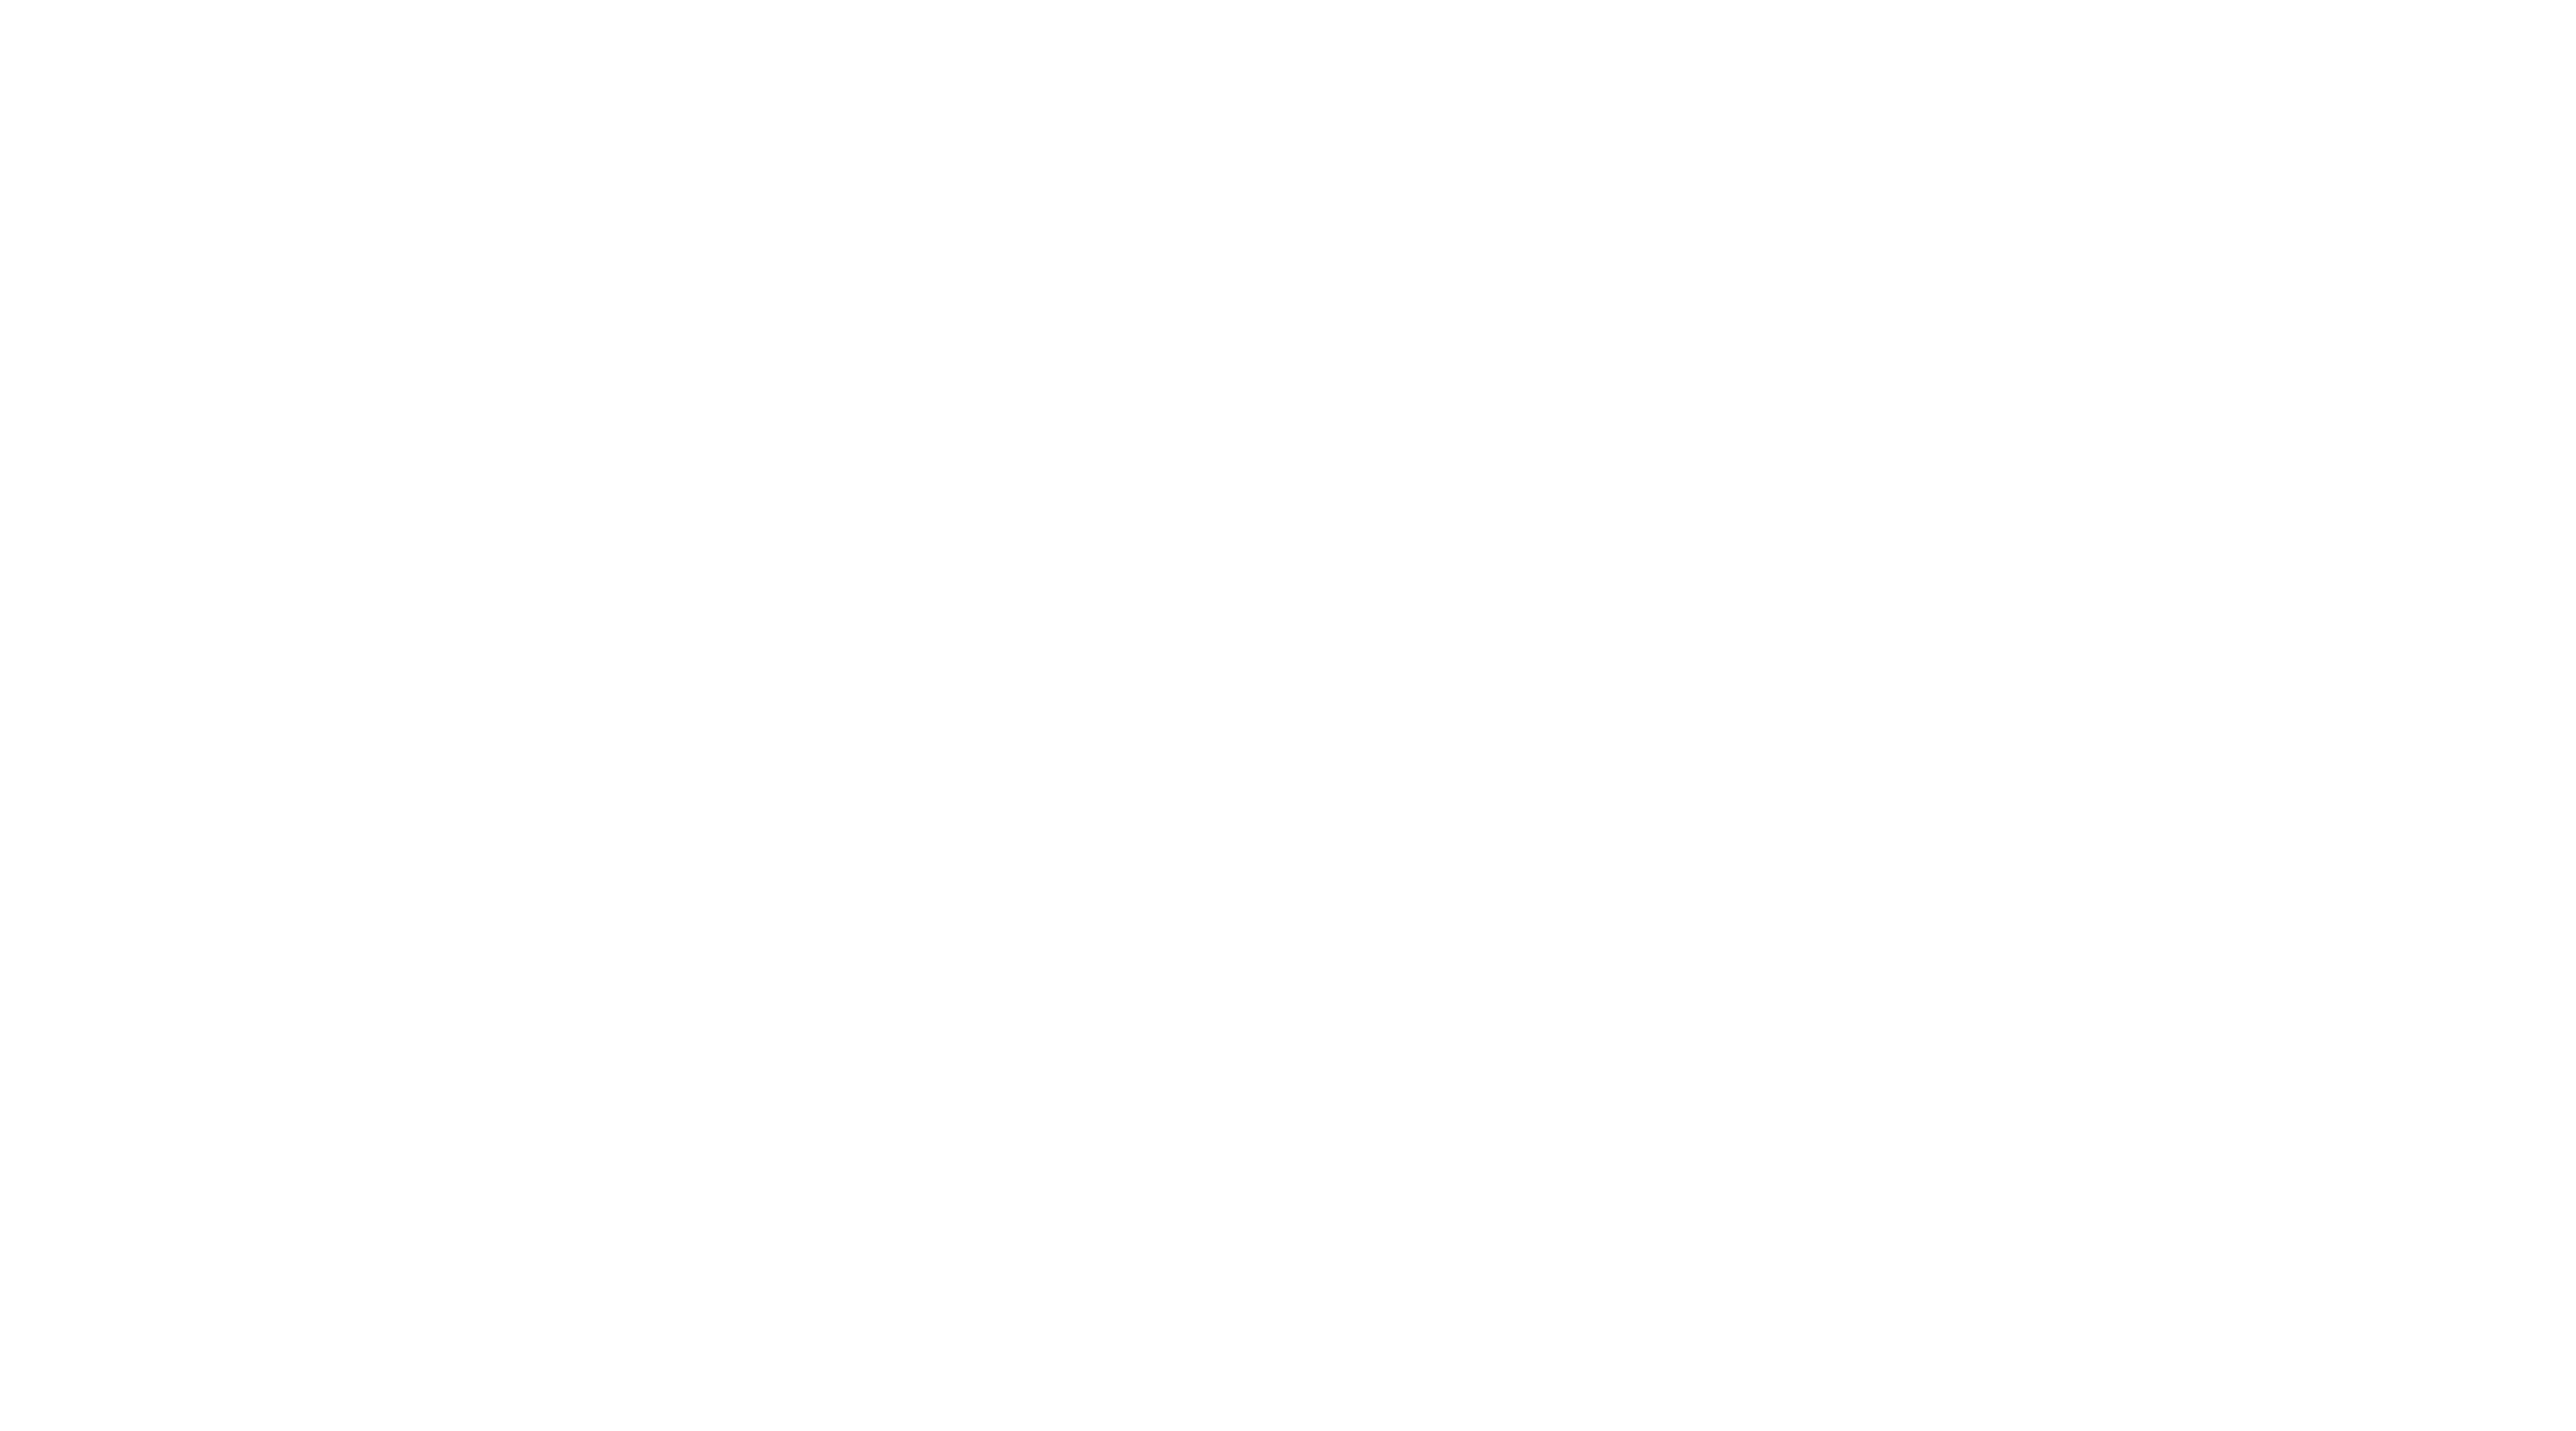

In [ ]:
#using CairoMakie
fig = Figure(size=(1800, 1000))

In [ ]:
# Animation setup
n = Observable(1)
b_slice = @lift interior(b_ts[$n], :, 1, :)
ζ_slice = @lift interior(ζ_ts[$n], :, 1, :)

u_slice = @lift interior(u_ts[$n], :, 1, :)
v_slice = @lift interior(v_ts[$n], :, 1, :)
w_slice = @lift interior(w_ts[$n], :, 1, :)

title_text = @lift "Day $(round(times[$n]/day, digits=1))"

Observable("Day 0.0")


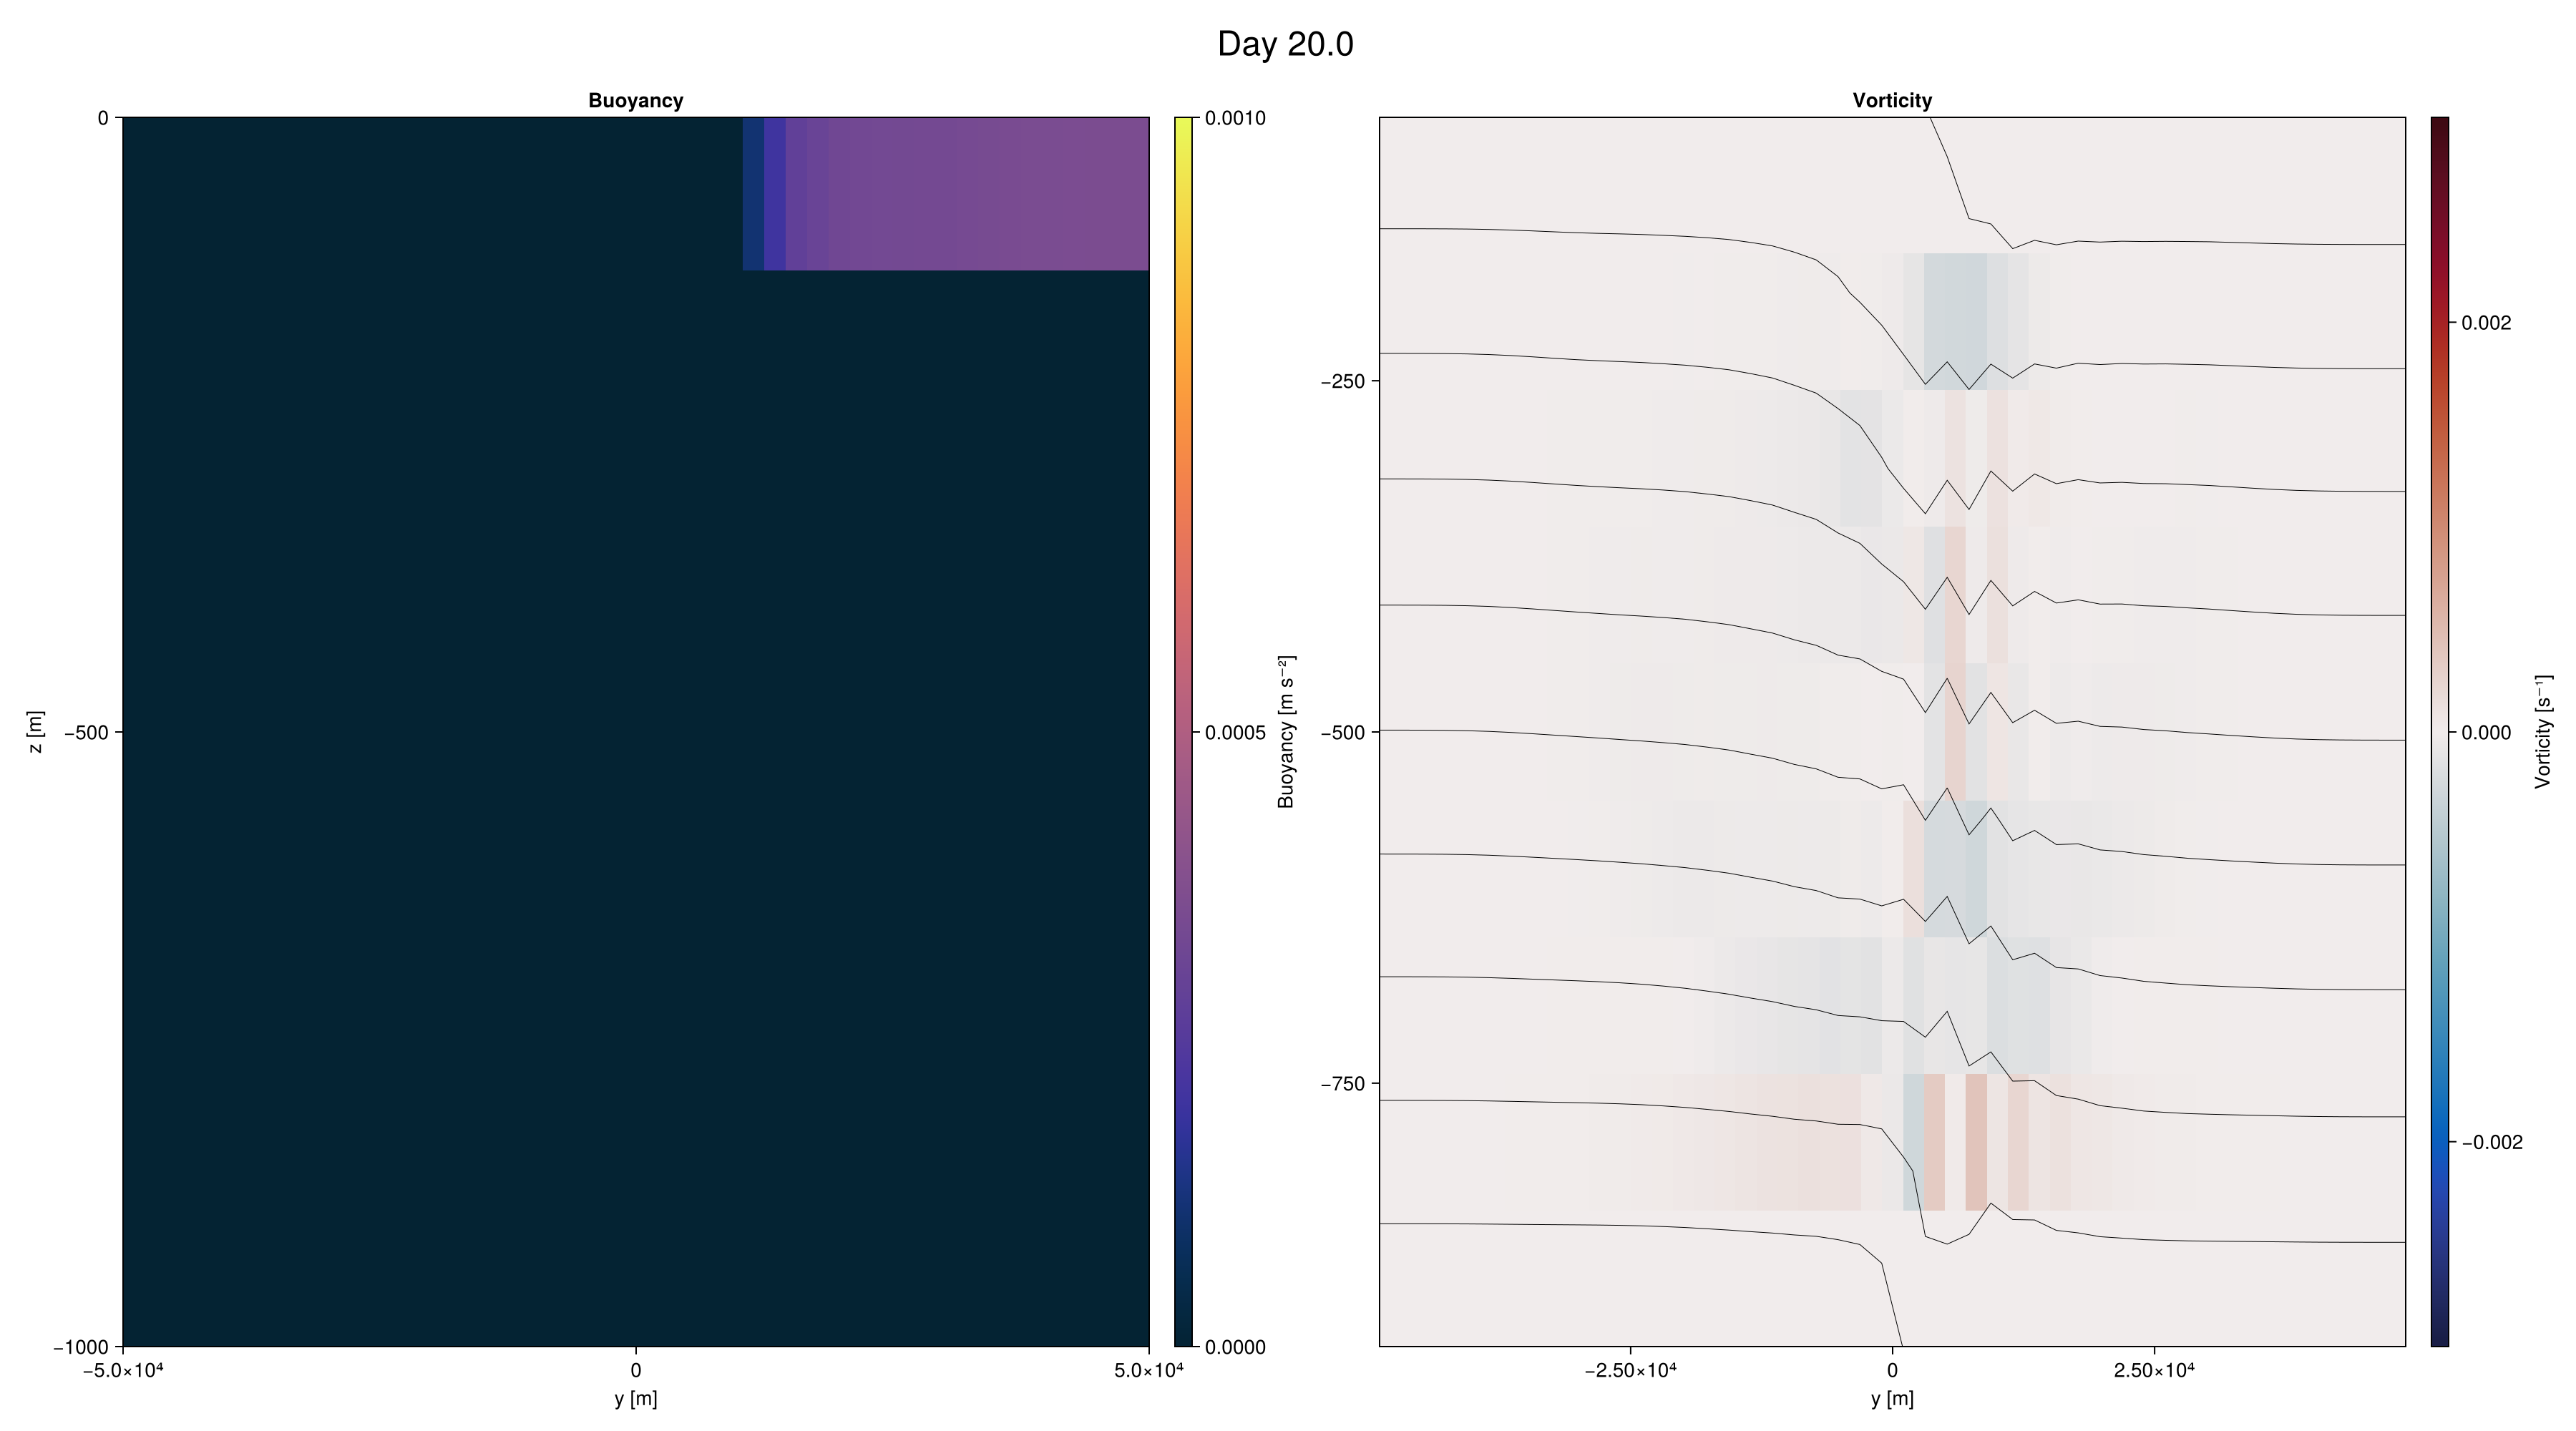

In [ ]:


# Animations of Buoyancy and Vorticity
empty!(fig)

# Buoyancy plot
ax_b = Axis(fig[1, 1], title="Buoyancy", xlabel="y [m]", ylabel="z [m]")
hm_b = heatmap!(ax_b, x, z, b_slice, colorrange=(0, Δb), colormap=:thermal)
Colorbar(fig[1, 2], hm_b, label="Buoyancy [m s⁻²]")
#(ax_b, x, z, b_slice ; levels=10, color=:black, linewidth=0.5)


# Vorticity plot
ax_ζ = Axis(fig[1, 3], title="Vorticity", xlabel="y [m]")
hm_ζ = heatmap!(ax_ζ, x, z, ζ_slice, colorrange=(-3e-3, 3e-3), colormap=:balance)
Colorbar(fig[1, 4], hm_ζ, label="Vorticity [s⁻¹]")
contour!(ax_ζ, x, z, b_slice ; levels=10, color=:black, linewidth=0.5)

Label(fig[0, :], title_text, fontsize=24)

# Create animation
frames = 1:length(times)
record(fig, filename * "_animation.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame 


     



In [ ]:
#animation of U only
#=

empty!(fig)

ax_u = Axis(fig[1, 1], title="U", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_u, x, z, u_slice; colorrange=(-5e-5, 5e-5), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="V [m s⁻1]")
contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

=#

In [ ]:
#animation of W only

#=

empty!(fig)

ax_w = Axis(fig[1, 1], title="W", xlabel="y [m]", ylabel="z [m]")
hm = heatmap!(ax_w, x, z, w_slice; colorrange=(-5e-5, 5e-5), colormap=:balance)
Colorbar(fig[1, 2], hm_b, label="W [m s⁻1]")
#contour!(ax_u, x, z, b_slice, levels=10, color=:black, linewidth=0.5)


# Create animation
frames = 1:length(times)
record(fig, filename * "_animation_velocities.mp4", frames, framerate=8) do i
    n[] = i
end

fig  # Display final frame

=#